In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

In [2]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [3]:
print(test_ind)

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 83]


In [293]:
#“Constant”: univariate model using only the average cycle life of the training set for all predictions

bat1_2 = {**batch1, **batch2}

prim_test_cycle=[]
Train_cycle=[]
secondary_cycle=[]
for i,j in enumerate(bat1_2.keys()):
    cycle=bat_dict[j]['cycle_life'].tolist()
    if i==83:
        prim_test_cycle.append(cycle)
        break
    if i%2==0:
        prim_test_cycle.append(cycle)
    if i%2==1:
        Train_cycle.append(cycle)
for i,j in enumerate(batch3.keys()):
    cycle=bat_dict[j]['cycle_life'].tolist()
    secondary_cycle.append(cycle)

cycle1=np.log10(Train_cycle)
cycle2=np.log10(prim_test_cycle)
cycle3=np.log10(secondary_cycle)    
    
    
arr=np.log10(np.array(Train_cycle)/2)
cyc=np.array(cycle1).ravel()

    
    
arr2=np.log10(np.array(prim_test_cycle)/2)  
cyc2=np.array(cycle2).ravel()

    
    
arr3=np.log10(np.array(secondary_cycle)/2)
cyc3=np.array(cycle3).ravel()

    
    
    
def Z_score(Train,prim_test,secondary):
    Z1=(Train-np.mean(Train))/np.std(Train)
    Z2=(prim_test-np.mean(Train))/np.std(Train)
    Z3=(secondary-np.mean(Train))/np.std(Train)
    return Z1, Z2, Z3    
Z1,Z2,Z3=Z_score(arr,arr2,arr3)    

print(secondary_cycle)

[[[1009.0]], [[1063.0]], [[1115.0]], [[1048.0]], [[828.0]], [[667.0]], [[1836.0]], [[828.0]], [[1039.0]], [[1078.0]], [[817.0]], [[932.0]], [[816.0]], [[858.0]], [[876.0]], [[1638.0]], [[1315.0]], [[1146.0]], [[1155.0]], [[813.0]], [[772.0]], [[1002.0]], [[825.0]], [[989.0]], [[1028.0]], [[850.0]], [[541.0]], [[858.0]], [[935.0]], [[731.0]], [[1284.0]], [[1158.0]], [[1093.0]], [[923.0]], [[796.0]], [[786.0]], [[1642.0]], [[1046.0]], [[940.0]], [[1801.0]]]


In [294]:
Train=Z1.reshape(-1,1)
label_=cyc
Train.shape,label_.shape

((41, 1), (41,))

In [295]:
from sklearn.linear_model import ElasticNetCV
regr=ElasticNetCV(cv=4)
regr.fit(Train,label_)

ElasticNetCV(cv=4)

In [296]:
print('Elastic Net CV alpha:',regr.alpha_)
print('Elastic Net CV coef:',regr.coef_)
print('Elastic Net CV intercept:',regr.intercept_)

Elastic Net CV alpha: 0.00032314794952087363
Elastic Net CV coef: [0.16138632]
Elastic Net CV intercept: 2.7939698976436373


In [297]:
pred1=regr.predict(Train)
print(pred1)

[3.33382604 3.15612806 3.03072899 2.93935021 2.89640711 2.856656
 2.93281938 2.89640711 2.74746588 3.00707317 2.93935021 2.93433524
 2.85058041 2.86383614 2.87031514 2.84751041 2.79028944 2.98475529
 2.84627629 2.78958581 2.47748924 2.64165122 2.64755321 2.70852026
 2.67865246 2.68407491 2.69384337 2.66385222 2.68943041 2.72189442
 2.66385222 2.67038954 2.6973417  2.69208357 2.71609389 2.6657301
 2.67956092 2.66196617 2.63264487 2.66479218 2.68765258]


In [298]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
from sklearn.metrics import mean_squared_error
rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
rmse1,MAPE1

Train RMSE, Mean Absolute Percentage Error


(0.5808168218787624, 0.03511394645639329)

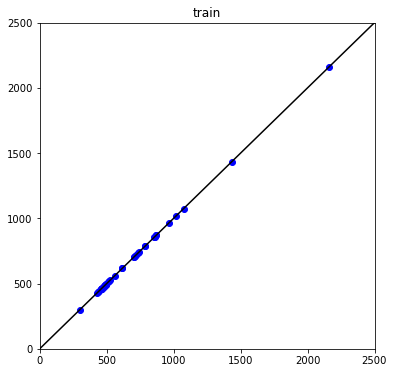

In [299]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()

In [300]:
Prim=Z2.reshape(-1,1)
label2=cyc2

pred2=regr.predict(Prim)
print(pred2)

Prim.shape,label2.shape

[3.26709087 3.34902061 3.23223248 2.8034461  3.0225748  2.94430787
 2.93534289 2.83942519 2.72761841 3.00579166 2.93129819 2.92515955
 2.96217376 2.9423316  2.87899702 2.84689379 2.81155456 2.7958778
 3.02133835 2.81355821 2.77744604 2.17098608 2.52535713 2.68137216
 2.74901513 2.66102006 2.68586743 2.68765258 2.70081204 2.71021475
 2.6947206  2.67316138 2.70681912 2.68227495 2.71525888 2.69821189
 2.72842999 2.66759989 2.69821189 2.66853177 2.66007189 2.63264487
 2.85302087]


((43, 1), (43,))

In [301]:
rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Train RMSE, Mean Absolute Percentage Error')
rmse2,MAPE2

Train RMSE, Mean Absolute Percentage Error


(0.730746451244094, 0.038974030919431586)

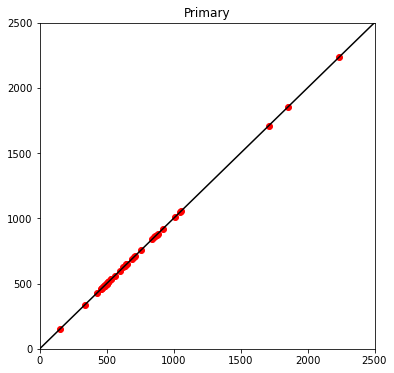

In [302]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()

In [303]:
sec=Z3.reshape(-1,1)
label3=cyc3

pred3=regr.predict(sec)
print(pred3)

sec.shape,label3.shape

[3.00364737 3.02626317 3.04698068 3.02009835 2.91788625 2.82409081
 3.26332694 2.91788625 3.01635697 3.0323416  2.91208472 2.96921215
 2.91155344 2.93332525 2.9423316  3.21382572 3.11854835 3.0588766
 3.06227002 2.90995568 2.88750854 3.00062743 2.9163117  2.99496259
 3.01173991 2.92926162 2.73326785 2.93332525 2.97060623 2.86383614
 3.10819966 3.06339529 3.03833603 2.96500283 2.90078887 2.89530472
 3.21488374 3.01926972 2.97291978 3.25497768]


((40, 1), (40,))

In [304]:
rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('Train RMSE, Mean Absolute Percentage Error')
rmse3,MAPE3

Train RMSE, Mean Absolute Percentage Error


(0.8335126313650288, 0.05445094784738265)

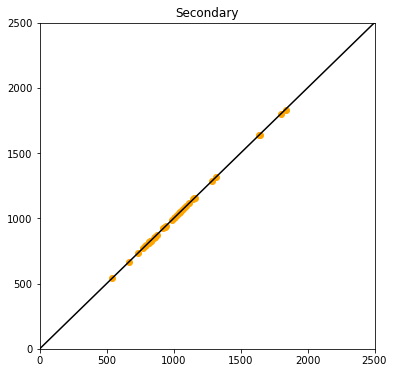

In [305]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

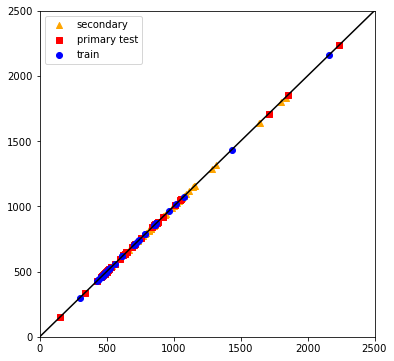

In [306]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.legend()
plt.show()

In [307]:
bat_dict['b1c0']['cycles']['99']['Qdlin'][-1]

1.0595346015979203

In [308]:
#“Discharge at cycle 100”: univariate model using only the discharge capacity at cycle 100
prim_test_Qdlin100=[]
Train_Qdlin100=[]
secondary_Qdlin100=[]
for i,j in enumerate(bat1_2.keys()):
    Qdlin100=bat_dict[j]['cycles']['99']['Qdlin'][-1]
    if i==83:
        prim_test_Qdlin100.append(Qdlin100)
        break
    if i%2==0:
        prim_test_Qdlin100.append(Qdlin100)
    if i%2==1:
        Train_Qdlin100.append(Qdlin100)
for i,j in enumerate(batch3.keys()):
    Qdlin100=bat_dict[j]['cycles']['99']['Qdlin'][-1]
    secondary_Qdlin100.append(Qdlin100)

In [309]:
Train_D100=np.array(Train_Qdlin100).reshape(-1,1)
Prim_D100=np.array(prim_test_Qdlin100).reshape(-1,1)
sec_D100=np.array(secondary_Qdlin100).reshape(-1,1)

In [310]:
Z1,Z2,Z3=Z_score(Train_D100,Prim_D100,sec_D100)

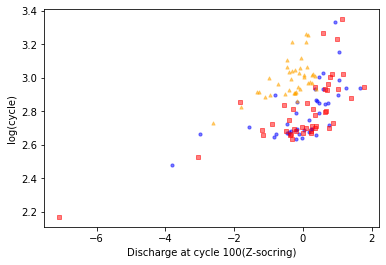

In [311]:
plt.scatter(Z1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Discharge at cycle 100(Z-socring)')
plt.show()

In [312]:
Train=Z1
Train.shape, label_.shape

((41, 1), (41,))

In [313]:
regr=ElasticNetCV(cv=4)
regr.fit(Train,label_)

ElasticNetCV(cv=4)

In [314]:
print('Elastic Net CV alpha:',regr.alpha_)
print('Elastic Net CV coef:',regr.coef_)
print('Elastic Net CV intercept:',regr.intercept_)

Elastic Net CV alpha: 0.00020166365436415258
Elastic Net CV coef: [0.10072084]
Elastic Net CV intercept: 2.7939698976436365


In [315]:
pred1=regr.predict(Train)
print(pred1)

[2.88836566 2.90049079 2.85282889 2.960488   2.71075917 2.77759513
 2.83005982 2.89766379 2.81154606 2.84127463 2.9186953  2.85146045
 2.86656034 2.83505193 2.83315336 2.84071018 2.7729821  2.8985276
 2.85980469 2.83952468 2.41092503 2.79117624 2.71001706 2.63475516
 2.75276954 2.7590317  2.77523938 2.4921346  2.79814086 2.74754391
 2.71608954 2.74594063 2.81951617 2.8167117  2.87041982 2.75298246
 2.81186544 2.83054029 2.77263857 2.78214815 2.77463698]


In [316]:
rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
rmse1,MAPE(10**label_,10**pred1)

Train RMSE, Mean Absolute Percentage Error


(276.7809904447936, 21.856824776737476)

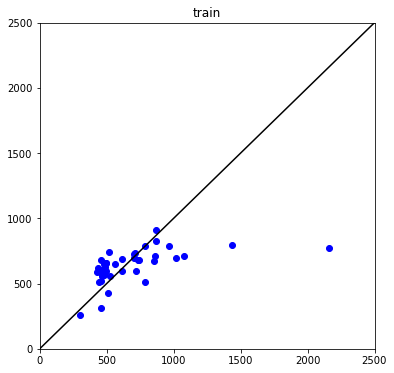

In [317]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()

In [318]:
pred2=regr.predict(Z2)
print(pred2)

[2.85248377 2.90928468 2.89447999 2.8617229  2.91235107 2.83031782
 2.89619177 2.73819546 2.70178719 2.87383337 2.85959677 2.86413991
 2.8657279  2.97191859 2.93406637 2.80643556 2.82426599 2.85754527
 2.87788156 2.76576859 2.82923722 2.08062856 2.48632531 2.74512216
 2.75274809 2.67711928 2.8179232  2.67332341 2.86886781 2.83108256
 2.76775006 2.79444825 2.79232318 2.77264215 2.82080251 2.80375813
 2.88060703 2.75915522 2.82947058 2.81857071 2.75504998 2.76186543
 2.60891311]


In [319]:
rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Train RMSE, Mean Absolute Percentage Error')
rmse2,MAPE2

Train RMSE, Mean Absolute Percentage Error


(342.85554785120286, 23.463186573713962)

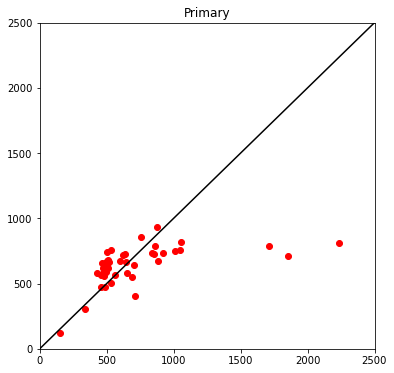

In [320]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()

In [321]:
pred3=regr.predict(Z3)
print(pred3)

[2.7976196  2.78143305 2.7699975  2.82463093 2.6654021  2.61177408
 2.80257995 2.77232534 2.79801851 2.7542756  2.77135204 2.8212763
 2.770592   2.83159601 2.78066921 2.76114881 2.78894401 2.78518677
 2.80613299 2.7673398  2.68356394 2.6958153  2.66021232 2.7592574
 2.83043709 2.75310997 2.53116949 2.78398563 2.80921621 2.77690652
 2.74762011 2.74663921 2.76043812 2.71950647 2.74117182 2.69830362
 2.80289314 2.81904073 2.81545217 2.80821409]


In [322]:
rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('Train RMSE, Mean Absolute Percentage Error')
rmse3,MAPE3

Train RMSE, Mean Absolute Percentage Error


(512.3912845019822, 40.457989467588284)

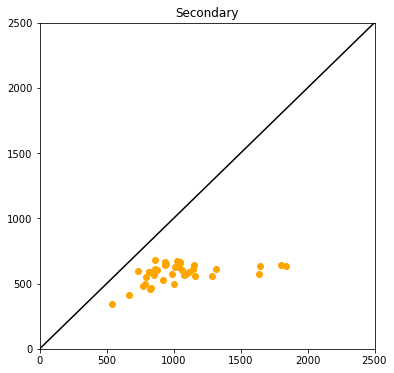

In [323]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

In [324]:
s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)
print(p_res.shape,s_res.shape)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])
print(his,his.shape)

(43,) (40,)
[[-1139.99380087]
 [-1425.50717937]
 [ -924.70401646]
 [   91.31559179]
 [ -236.75726032]
 [ -203.42208507]
 [  -74.60660872]
 [ -143.73778708]
 [  -30.7460521 ]
 [ -266.11750873]
 [ -130.23635075]
 [ -110.62533414]
 [ -182.94618205]
 [   61.38627392]
 [  102.14480332]
 [  -62.62324985]
 [   19.21528757]
 [   95.35283346]
 [ -296.11366351]
 [  -67.86569933]
 [   75.89657336]
 [  -27.5994263 ]
 [  -28.57421226]
 [   76.06064071]
 [    4.91094534]
 [   17.46579263]
 [  172.54155192]
 [  -15.67181838]
 [  237.38018548]
 [  164.77033461]
 [   90.80092974]
 [  151.94292073]
 [  110.90221013]
 [  111.43697116]
 [  142.91544207]
 [  137.44096491]
 [  224.63861146]
 [  109.32169874]
 [  176.25930564]
 [  192.52263303]
 [  111.91839934]
 [  148.91695023]
 [ -306.63797788]
 [ -381.49151844]
 [ -458.44885393]
 [ -526.15972803]
 [ -380.22380377]
 [ -365.19067663]
 [ -257.95217769]
 [-1201.28326296]
 [ -235.99505219]
 [ -410.9148716 ]
 [ -510.09511737]
 [ -226.32031256]
 [ -269.36206007

(0.0, 30.0)

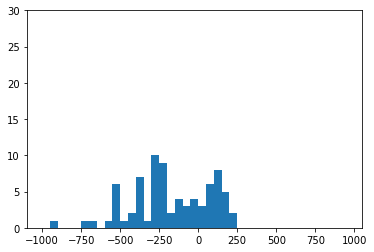

In [325]:
bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)

(array([ 0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  6.,  1.,  2.,  7.,
         1., 10.,  9.,  2.,  4.,  3.,  4.,  3.,  6.,  8.,  5.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

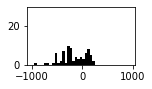

In [326]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

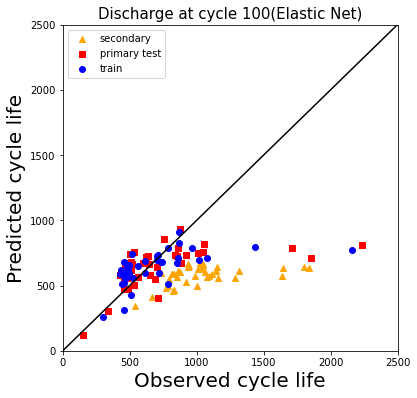

In [327]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Discharge at cycle 100(Elastic Net)',size=15)
plt.legend()
plt.show()

RidgeCV alpha: 10.0
RidgeCV coef: [0.08106088]
RidgeCV intercept: 2.7939698976436365
Train RMSE, Mean Absolute Percentage Error
283.77080619078225 21.79516747844838


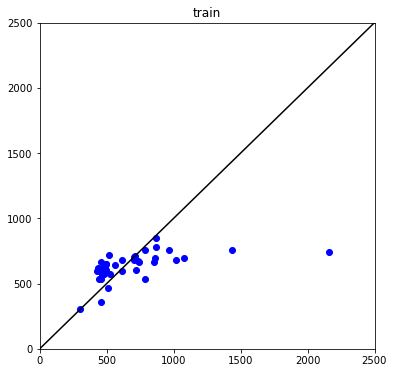

Prim RMSE, Mean Absolute Percentage Error
350.8933690467897 23.022559222586406


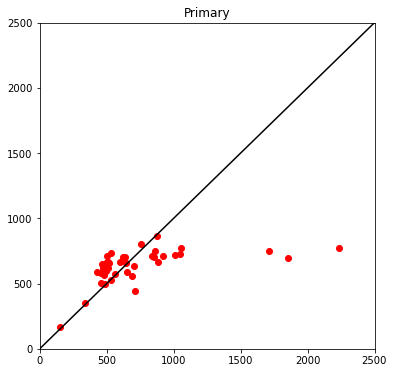

sec RMSE, Mean Absolute Percentage Error
507.72970416841326 39.541284707932995


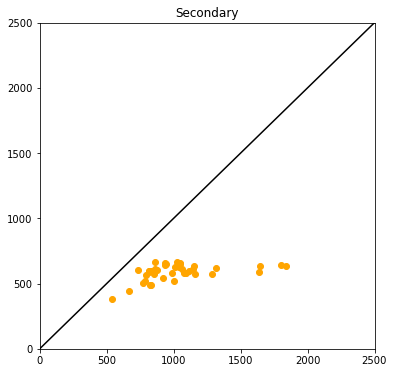

(0.0, 30.0)

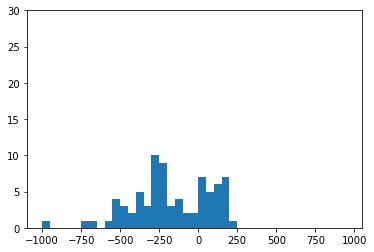

In [328]:
Train=Z1
from sklearn.linear_model import RidgeCV
regr=RidgeCV(cv=4)
regr.fit(Train,label_)
print('RidgeCV alpha:',regr.alpha_)
print('RidgeCV coef:',regr.coef_)
print('RidgeCV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()

pred2=regr.predict(Z2)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()

pred3=regr.predict(Z3)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)



(array([ 1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  4.,  3.,  2.,  5.,
         3., 10.,  9.,  3.,  4.,  2.,  2.,  7.,  5.,  6.,  7.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

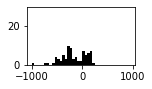

In [329]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

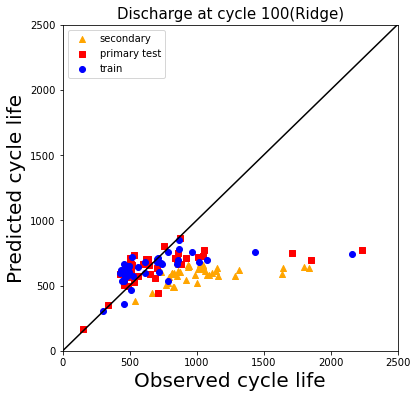

In [330]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Discharge at cycle 100(Ridge)',size=15)
plt.legend()
plt.show()

LassoCV alpha: 0.00010083182718207628
LassoCV coef: [0.100731]
LassoCV intercept: 2.7939698976436365
Train RMSE, Mean Absolute Percentage Error
276.7777330841112 21.85705853982081


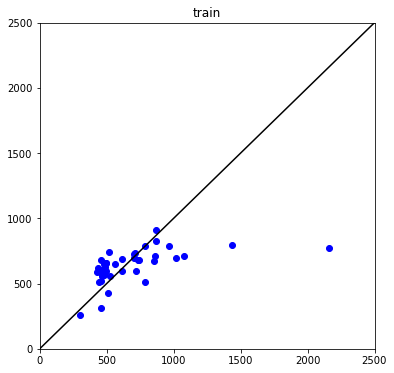

Prim RMSE, Mean Absolute Percentage Error
342.8517255023496 23.46384244149282


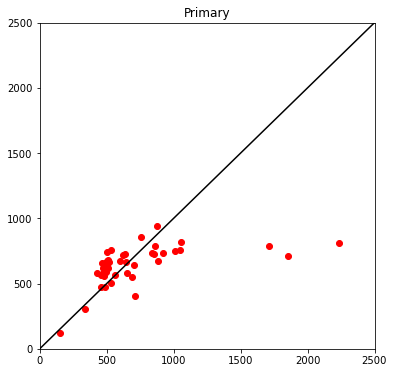

sec RMSE, Mean Absolute Percentage Error
512.3937158526895 40.458447148236125


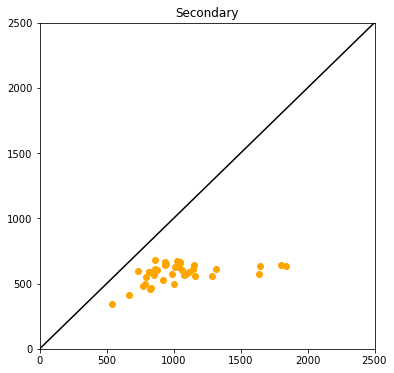

(0.0, 30.0)

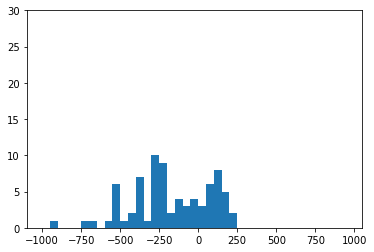

In [331]:
Train=Z1
from sklearn.linear_model import LassoCV
regr=LassoCV(cv=4)
regr.fit(Train,label_)
print('LassoCV alpha:',regr.alpha_)
print('LassoCV coef:',regr.coef_)
print('LassoCV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()

pred2=regr.predict(Z2)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()

pred3=regr.predict(Z3)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)



(array([ 0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  6.,  1.,  2.,  7.,
         1., 10.,  9.,  2.,  4.,  3.,  4.,  3.,  6.,  8.,  5.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

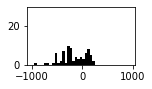

In [332]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

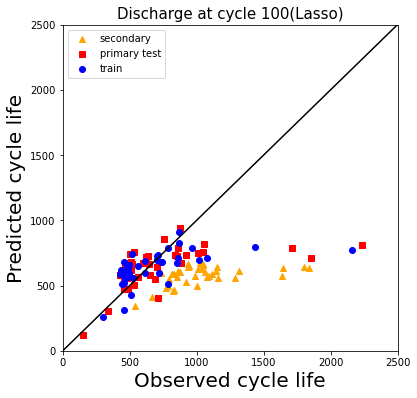

In [333]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Discharge at cycle 100(Lasso)',size=15)
plt.legend()
plt.show()

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32675138491370864, tolerance: 0.00010703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

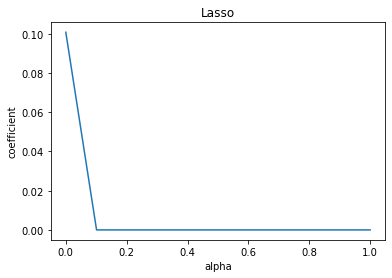

In [334]:
Y_lasso=[]
X_lasso=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Lasso(alpha=i)
    regrplot.fit(Train,label_)
    Y_lasso.append(regrplot.coef_)
    X_lasso.append(i)
Y_=np.array(Y_lasso)    

plt.plot(X_lasso,Y_)

plt.title('Lasso')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

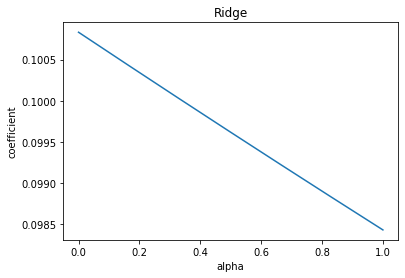

In [335]:
Y_Ridge=[]
X_Ridge=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Ridge(alpha=i)
    regrplot.fit(Train,label_)
    Y_Ridge.append(regrplot.coef_)
    X_Ridge.append(i)
Y_=np.array(Y_Ridge)    

plt.plot(X_Ridge,Y_)

plt.title('Ridge')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32675138491370864, tolerance: 0.00010703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

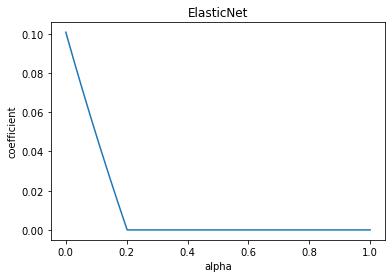

In [336]:
from sklearn.linear_model import ElasticNet
Y_ElasticNet=[]
X_ElasticNet=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=ElasticNet(alpha=i)
    regrplot.fit(Train,label_)
    Y_ElasticNet.append(regrplot.coef_)
    X_ElasticNet.append(i)
Y_=np.array(Y_ElasticNet)    

plt.plot(X_ElasticNet,Y_)

plt.title('ElasticNet')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

In [337]:
bat_dict['b1c0']['summary']['QD'][90]

1.0760405

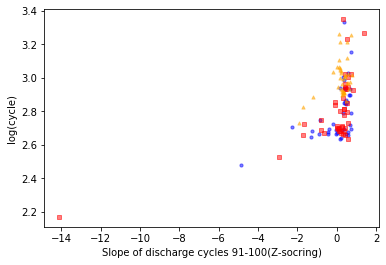

In [338]:
# “Slope of discharge cycles 91-100”: univariate model using only the slope of the linear fit for discharge capacity, cycles 91-100
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(91,101)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(91,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
        
    if i==83:
        prim.append(reg.coef_)
        break
    if i%2==0:
        prim.append(reg.coef_)
    if i%2==1:
        Train.append(reg.coef_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(91,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.coef_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z1,Z2,Z3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Slope of discharge cycles 91-100(Z-socring)')
plt.show()

Elastic Net CV alpha: 0.007734321377505193
Elastic Net CV coef: [0.07354868]
Elastic Net CV intercept: 2.793969897643637
Train RMSE, Mean Absolute Percentage Error
305.79685037128706 24.657479023209035


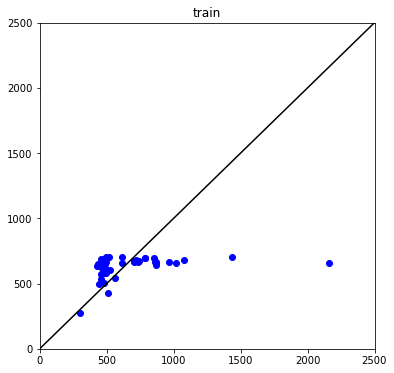

Prim RMSE, Mean Absolute Percentage Error
366.59317871625433 25.89278650845265


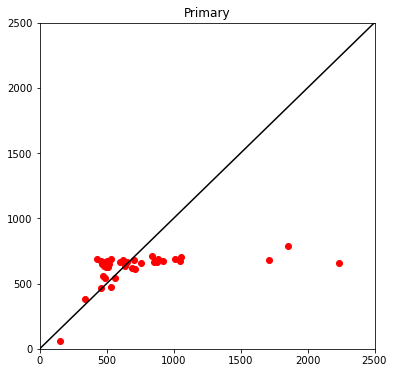

sec RMSE, Mean Absolute Percentage Error
465.2628238209875 33.39870026656289


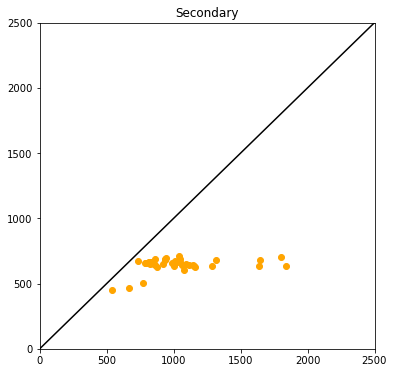

(0.0, 30.0)

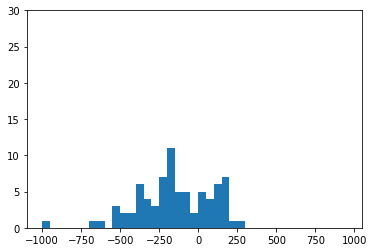

In [339]:
Train=Z1

regr=ElasticNetCV(cv=4)
regr.fit(Train,label_)
print('Elastic Net CV alpha:',regr.alpha_)
print('Elastic Net CV coef:',regr.coef_)
print('Elastic Net CV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()

pred2=regr.predict(Z2)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()

pred3=regr.predict(Z3)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)



(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  3.,  2.,  2.,  6.,
         4.,  3.,  7., 11.,  5.,  5.,  2.,  5.,  4.,  6.,  7.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

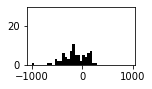

In [340]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

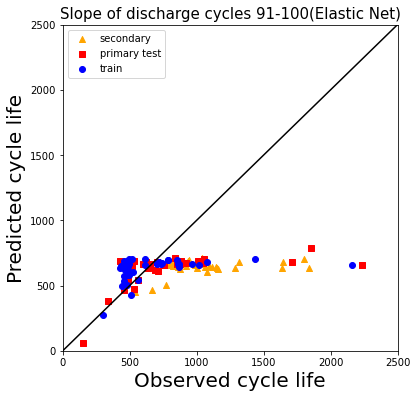

In [341]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Slope of discharge cycles 91-100(Elastic Net)',size=15)
plt.legend()
plt.show()

RidgeCV alpha: 10.0
RidgeCV coef: [0.06246492]
RidgeCV intercept: 2.793969897643637
Train RMSE, Mean Absolute Percentage Error
307.65697023695066 24.65045238680179


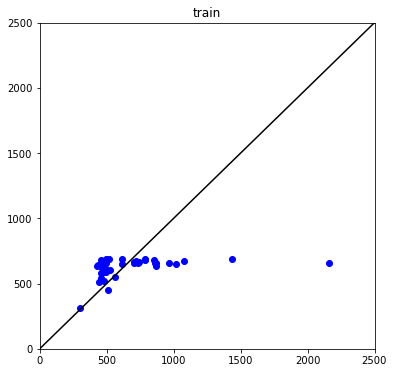

Prim RMSE, Mean Absolute Percentage Error
370.10865416596806 25.645742370931774


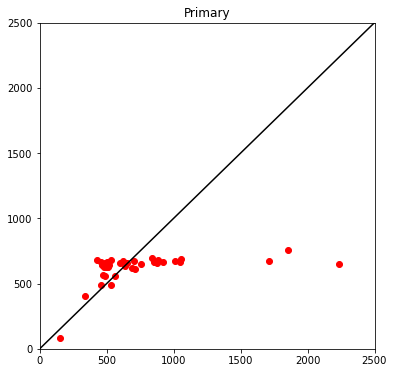

sec RMSE, Mean Absolute Percentage Error
468.96301573315276 33.69100114772646


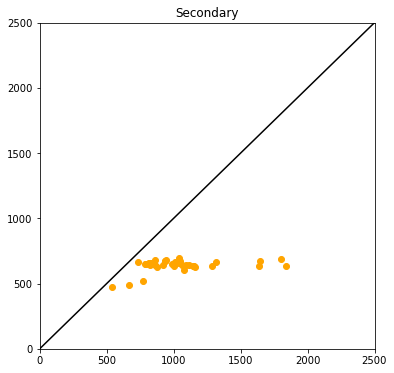

(0.0, 30.0)

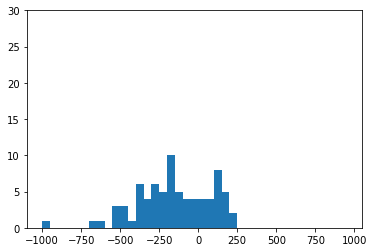

In [342]:
Train=Z1
from sklearn.linear_model import RidgeCV
regr=RidgeCV(cv=4)
regr.fit(Train,label_)
print('RidgeCV alpha:',regr.alpha_)
print('RidgeCV coef:',regr.coef_)
print('RidgeCV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()

pred2=regr.predict(Z2)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()

pred3=regr.predict(Z3)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)



(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  3.,  3.,  1.,  6.,
         4.,  6.,  5., 10.,  5.,  4.,  4.,  4.,  4.,  8.,  5.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

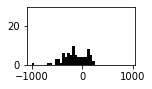

In [343]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

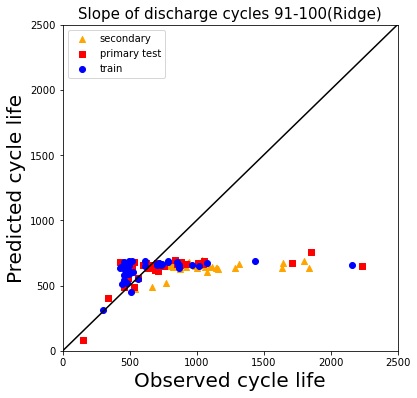

In [344]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Slope of discharge cycles 91-100(Ridge)',size=15)
plt.legend()
plt.show()

LassoCV alpha: 0.0038671606887525955
LassoCV coef: [0.07383311]
LassoCV intercept: 2.793969897643637
Train RMSE, Mean Absolute Percentage Error
305.7537655531325 24.660939661072295


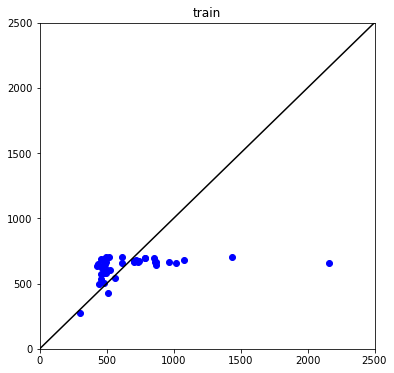

Prim RMSE, Mean Absolute Percentage Error
366.50506519010406 25.89765082215589


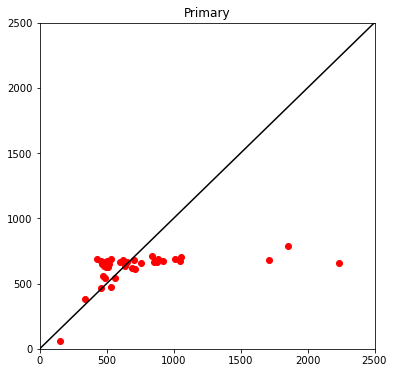

sec RMSE, Mean Absolute Percentage Error
465.1685224685881 33.390985946795226


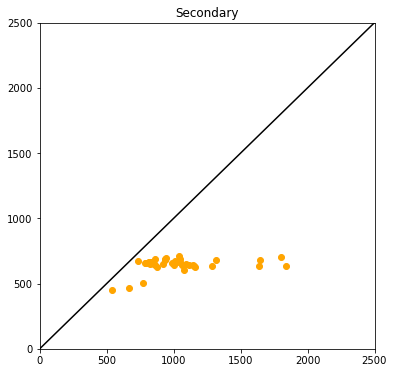

(0.0, 30.0)

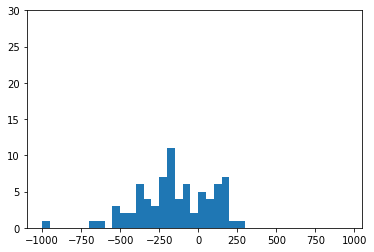

In [345]:
Train=Z1
from sklearn.linear_model import LassoCV
regr=LassoCV(cv=4)
regr.fit(Train,label_)
print('LassoCV alpha:',regr.alpha_)
print('LassoCV coef:',regr.coef_)
print('LassoCV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()

pred2=regr.predict(Z2)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()

pred3=regr.predict(Z3)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)



(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  3.,  2.,  2.,  6.,
         4.,  3.,  7., 11.,  4.,  6.,  2.,  5.,  4.,  6.,  7.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

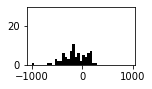

In [346]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

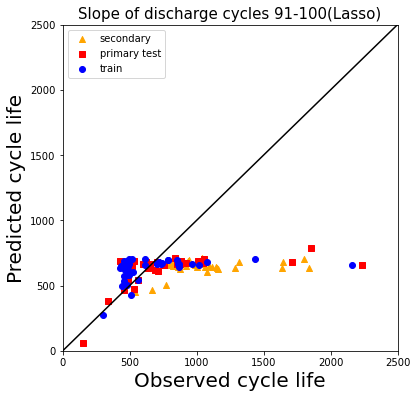

In [347]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Slope of discharge cycles 91-100(Lasso)',size=15)
plt.legend()
plt.show()

In [348]:
'''
Train= np.array([])
Train= np.append(Train,Z1)
Train= np.append(Train,Z2)
Train= np.append(Train,Z3)
print(Train.shape)

cycle=np.array([])
cycle=np.append(cycle,cycle1)
cycle=np.append(cycle,cycle2)
cycle=np.append(cycle,cycle3)
print(cycle.shape)
'''

'\nTrain= np.array([])\nTrain= np.append(Train,Z1)\nTrain= np.append(Train,Z2)\nTrain= np.append(Train,Z3)\nprint(Train.shape)\n\ncycle=np.array([])\ncycle=np.append(cycle,cycle1)\ncycle=np.append(cycle,cycle2)\ncycle=np.append(cycle,cycle3)\nprint(cycle.shape)\n'

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4114107596742778, tolerance: 0.00010703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

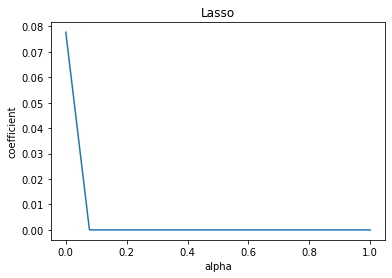

In [349]:
Y_lasso=[]
X_lasso=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Lasso(alpha=i)
    regrplot.fit(Train,label_)
    Y_lasso.append(regrplot.coef_)
    X_lasso.append(i)
Y_=np.array(Y_lasso)    

plt.plot(X_lasso,Y_)

plt.title('Lasso')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

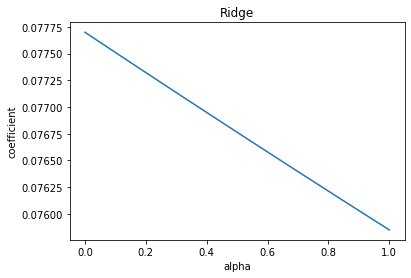

In [350]:
Y_Ridge=[]
X_Ridge=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Ridge(alpha=i)
    regrplot.fit(Train,label_)
    Y_Ridge.append(regrplot.coef_)
    X_Ridge.append(i)
Y_=np.array(Y_Ridge)    

plt.plot(X_Ridge,Y_)

plt.title('Ridge')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4114107596742778, tolerance: 0.00010703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

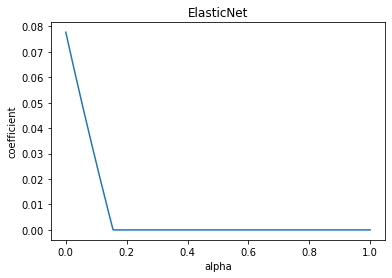

In [351]:
from sklearn.linear_model import ElasticNet
Y_ElasticNet=[]
X_ElasticNet=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=ElasticNet(alpha=i)
    regrplot.fit(Train,label_)
    Y_ElasticNet.append(regrplot.coef_)
    X_ElasticNet.append(i)
Y_=np.array(Y_ElasticNet)    

plt.plot(X_ElasticNet,Y_)

plt.title('ElasticNet')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

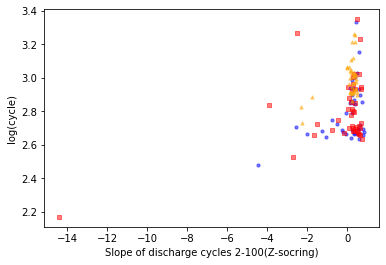

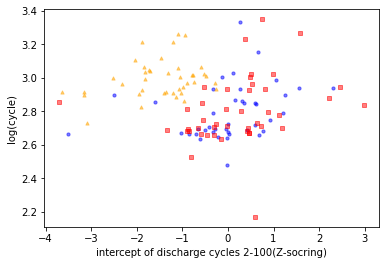

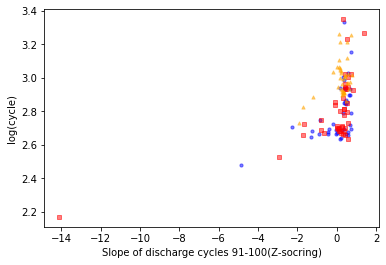

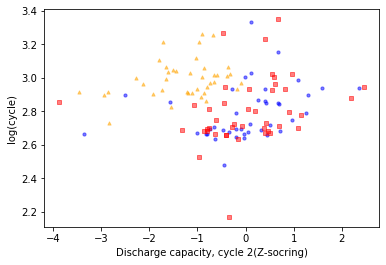

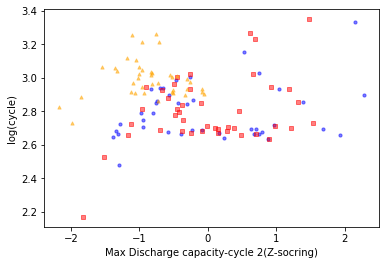

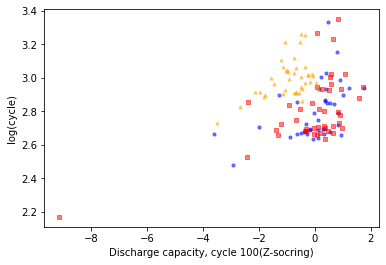

In [352]:
#Slope of capacity fade curve, cycles 2 to 100
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(2,101)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
        
    if i==83:
        prim.append(reg.coef_)
        break
    if i%2==0:
        prim.append(reg.coef_)
    if i%2==1:
        Train.append(reg.coef_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.coef_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z1_1,Z1_2,Z1_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z1_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z1_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z1_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Slope of discharge cycles 2-100(Z-socring)')
plt.show()

#Slope of capacity fade curve, cycles 2 to 100
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(2,101)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
    if i==83:
        prim.append(reg.intercept_)
        break
    if i%2==0:
        prim.append(reg.intercept_)
    if i%2==1:
        Train.append(reg.intercept_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.intercept_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z2_1,Z2_2,Z2_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z2_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z2_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z2_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('intercept of discharge cycles 2-100(Z-socring)')
plt.show()

# “Slope of discharge cycles 91-100”: univariate model using only the slope of the linear fit for discharge capacity, cycles 91-100
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(91,101)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(91,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
        
    if i==83:
        prim.append(reg.coef_)
        break
    if i%2==0:
        prim.append(reg.coef_)
    if i%2==1:
        Train.append(reg.coef_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(91,101):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.coef_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z3_1,Z3_2,Z3_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z3_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z3_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z3_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Slope of discharge cycles 91-100(Z-socring)')
plt.show()

# “Discharge capacity, cycle 2
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    Cycle2=bat_dict[j]['summary']['QD'][2]

    if i==83:
        prim.append(Cycle2)
        break
    if i%2==0:
        prim.append(Cycle2)
    if i%2==1:
        Train.append(Cycle2)
for i,j in enumerate(batch3.keys()):
    Cycle2=bat_dict[j]['summary']['QD'][2]
    secondary.append(Cycle2)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z4_1,Z4_2,Z4_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z4_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z4_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z4_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Discharge capacity, cycle 2(Z-socring)')
plt.show()

# “Max Discharge capacity-cycle 2'
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    a=np.array(bat_dict[j]['summary']['QD'])
    de=np.where(a>1.2)
    a=np.delete(a,de)
    max_Q_cycle2=max(a)-a[2]
    
    if i==83:
        prim.append(max_Q_cycle2)
        break
    if i%2==0:
        prim.append(max_Q_cycle2)
    if i%2==1:
        Train.append(max_Q_cycle2)
for i,j in enumerate(batch3.keys()):
    a=np.array(bat_dict[j]['summary']['QD'])
    de=np.where(a>1.2)
    a=np.delete(a,de)
    max_Q_cycle2=max(a)-a[2]
    secondary.append(max_Q_cycle2)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z5_1,Z5_2,Z5_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z5_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z5_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z5_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Max Discharge capacity-cycle 2(Z-socring)')
plt.show()

# “Discharge capacity, cycle 100'
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    Cycle100=bat_dict[j]['summary']['QD'][100]

    if i==83:
        prim.append(Cycle100)
        break
    if i%2==0:
        prim.append(Cycle100)
    if i%2==1:
        Train.append(Cycle100)
for i,j in enumerate(batch3.keys()):
    Cycle100=bat_dict[j]['summary']['QD'][100]
    secondary.append(Cycle100)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z6_1,Z6_2,Z6_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z6_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z6_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z6_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Discharge capacity, cycle 100(Z-socring)')
plt.show()

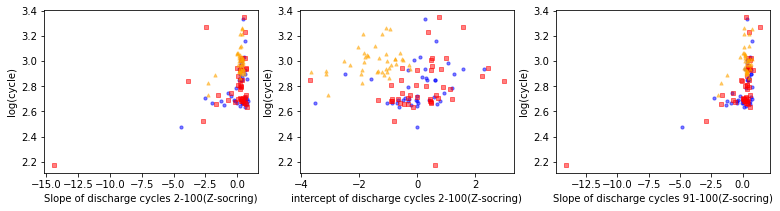

<Figure size 432x288 with 0 Axes>

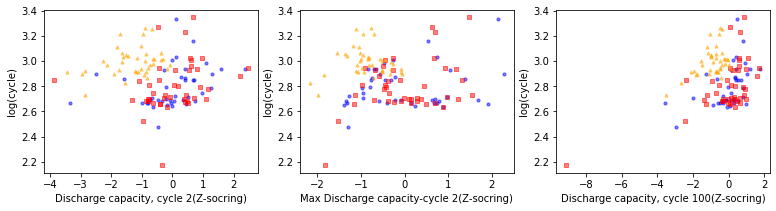

In [353]:
fig=plt.figure(figsize=(13,3))
ax1=fig.add_subplot(1,3,1)
ax1.scatter(Z1_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax1.scatter(Z1_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax1.scatter(Z1_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax1.set_ylabel('log(cycle)')
ax1.set_xlabel('Slope of discharge cycles 2-100(Z-socring)')

ax2=fig.add_subplot(1,3,2)
ax2.scatter(Z2_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax2.scatter(Z2_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax2.scatter(Z2_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax2.set_ylabel('log(cycle)')
ax2.set_xlabel('intercept of discharge cycles 2-100(Z-socring)')

ax3=fig.add_subplot(1,3,3)
ax3.scatter(Z3_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax3.scatter(Z3_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax3.scatter(Z3_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax3.set_ylabel('log(cycle)')
ax3.set_xlabel('Slope of discharge cycles 91-100(Z-socring)')
plt.show()

plt.clf()
fig=plt.figure(figsize=(13,3))
ax4=fig.add_subplot(1,3,1)
ax4.scatter(Z4_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax4.scatter(Z4_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax4.scatter(Z4_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax4.set_ylabel('log(cycle)')
ax4.set_xlabel('Discharge capacity, cycle 2(Z-socring)')

ax5=fig.add_subplot(1,3,2)
ax5.scatter(Z5_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax5.scatter(Z5_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax5.scatter(Z5_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax5.set_ylabel('log(cycle)')
ax5.set_xlabel('Max Discharge capacity-cycle 2(Z-socring)')

ax6=fig.add_subplot(1,3,3)
ax6.scatter(Z6_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax6.scatter(Z6_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax6.scatter(Z6_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax6.set_ylabel('log(cycle)')
ax6.set_xlabel('Discharge capacity, cycle 100(Z-socring)')
plt.show()

In [354]:
Train=np.hstack([Z1_1,Z2_1,Z3_1,Z4_1,Z5_1,Z6_1])
Train.shape , label_.shape

((41, 6), (41,))

In [355]:
label_,label2,label3

(array([3.33445375, 3.15654915, 3.03100428, 2.93951925, 2.89652622,
        2.85672889, 2.93298082, 2.89652622, 2.74741181, 3.00732095,
        2.93951925, 2.93449845, 2.85064624, 2.86391738, 2.87040391,
        2.84757266, 2.79028516, 2.98497713, 2.84633711, 2.78958071,
        2.47712125, 2.64147411, 2.64738297, 2.7084209 , 2.67851838,
        2.68394713, 2.69372695, 2.66370093, 2.68930886, 2.72181062,
        2.66370093, 2.67024585, 2.69722934, 2.6919651 , 2.71600334,
        2.66558099, 2.6794279 , 2.66181269, 2.63245729, 2.66464198,
        2.68752896]),
 array([3.26764098, 3.34966598, 3.23274206, 2.80345712, 3.02284061,
        2.94448267, 2.93550727, 2.83947805, 2.72754126, 3.00603795,
        2.93145787, 2.92531209, 2.96236934, 2.94250411, 2.87909588,
        2.84695533, 2.81157501, 2.79588002, 3.02160272, 2.81358099,
        2.77742682, 2.17026172, 2.52504481, 2.68124124, 2.74896286,
        2.66086548, 2.68574174, 2.68752896, 2.70070372, 2.71011737,
        2.6946052 , 2.6730

Elastic Net CV alpha: 0.0585073048560448
Elastic Net CV coef: [0.         0.         0.03784796 0.00464631 0.         0.0146417 ]
Elastic Net CV intercept: 2.793969897643637
Train RMSE, Mean Absolute Percentage Error
307.27112922852257 24.80690693376294


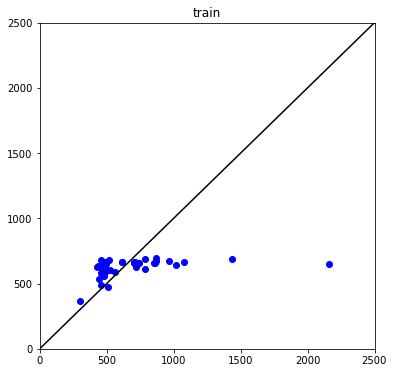

Prim RMSE, Mean Absolute Percentage Error
373.1800483101062 25.24654989359194


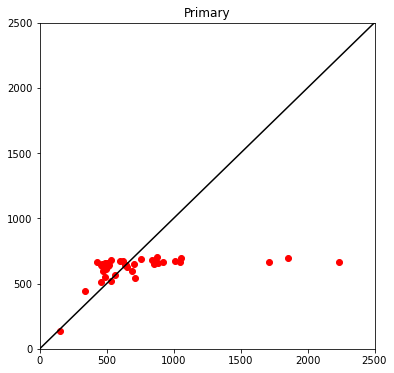

sec RMSE, Mean Absolute Percentage Error
496.78196013360804 37.22402717140707


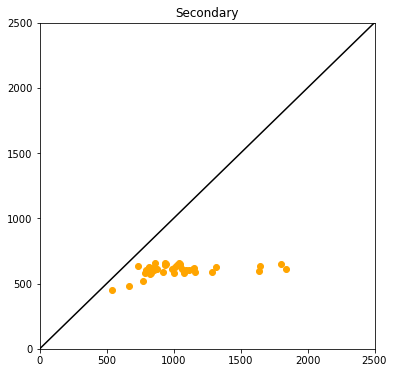

(0.0, 30.0)

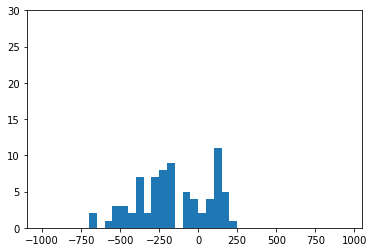

In [369]:
#elasticnet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
regr=ElasticNetCV(cv=4,tol=0.1)
#regr=ElasticNet(alpha=0.0000005)
regr.fit(Train,label_)
print('Elastic Net CV alpha:',regr.alpha_)
print('Elastic Net CV coef:',regr.coef_)
print('Elastic Net CV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()


prim=np.hstack([Z1_2,Z2_2,Z3_2,Z4_2,Z5_2,Z6_2])
pred2=regr.predict(prim)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()


sec=np.hstack([Z1_3,Z2_3,Z3_3,Z4_3,Z5_3,Z6_3])
pred3=regr.predict(sec)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  3.,  3.,  2.,  7.,
         2.,  7.,  8.,  9.,  0.,  5.,  4.,  2.,  4., 11.,  5.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

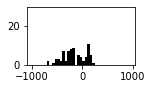

In [370]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

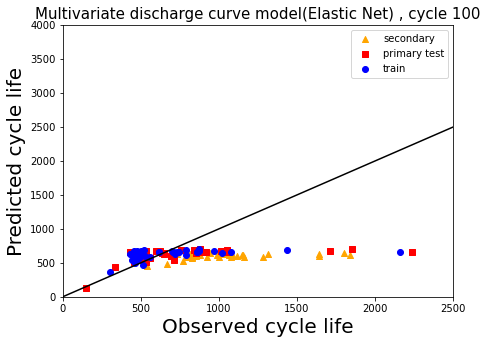

In [371]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(7,5))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,4000])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Multivariate discharge curve model(Elastic Net) , cycle 100',size=15)
plt.legend()
plt.show()

In [359]:
print(10**pred2)
print(10**label2)

[1.70101919e+01 9.80921130e+02 8.46863207e+02 5.60274491e+02
 9.22805592e+02 8.29968717e+02 1.08705102e+03 2.00611598e-01
 5.68261020e+02 7.86900947e+02 6.51066177e+02 7.72487989e+02
 6.93835477e+02 9.56127646e+02 8.91978034e+02 6.57927218e+02
 6.33996079e+02 7.14934729e+02 6.82230000e+02 5.06766591e+02
 7.78798497e+02 2.28165041e+03 3.64237951e+02 4.80045679e+02
 3.62680406e+02 4.08242735e+02 6.26545083e+02 4.02955942e+02
 7.01377812e+02 5.75122609e+02 4.95897446e+02 4.46595777e+02
 5.36221608e+02 4.65349852e+02 6.27644425e+02 5.10459203e+02
 6.50751601e+02 4.90485846e+02 5.98757288e+02 6.37234772e+02
 6.09727330e+02 6.61579354e+02 2.00265726e+02]
[1852. 2237. 1709.  636. 1054.  880.  862.  691.  534. 1014.  854.  842.
  917.  876.  757.  703.  648.  625. 1051.  651.  599.  148.  335.  480.
  561.  458.  485.  487.  502.  513.  495.  471.  509.  481.  519.  499.
  535.  465.  499.  466.  457.  429.  713.]


C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.263959696471317, tolerance: 0.10703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

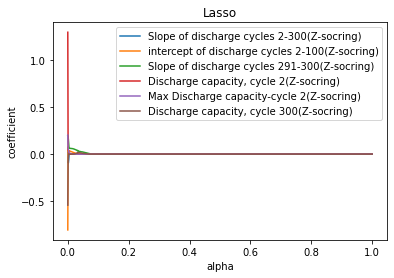

In [362]:
Y_lasso=[]
X_lasso=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Lasso(alpha=i,tol=0.1)
    regrplot.fit(Train,label_)
    Y_lasso.append(regrplot.coef_)
    X_lasso.append(i)
Y_=np.array(Y_lasso)    

plt.plot(X_lasso,Y_[:,0],label='Slope of discharge cycles 2-300(Z-socring)')
plt.plot(X_lasso,Y_[:,1],label='intercept of discharge cycles 2-100(Z-socring)')
plt.plot(X_lasso,Y_[:,2],label='Slope of discharge cycles 291-300(Z-socring)')
plt.plot(X_lasso,Y_[:,3],label='Discharge capacity, cycle 2(Z-socring)')
plt.plot(X_lasso,Y_[:,4],label='Max Discharge capacity-cycle 2(Z-socring)')
plt.plot(X_lasso,Y_[:,5],label='Discharge capacity, cycle 300(Z-socring)')

plt.title('Lasso')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

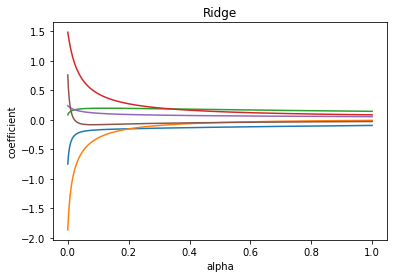

In [361]:
Y_Ridge=[]
X_Ridge=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Ridge(alpha=i,tol=0.1)
    regrplot.fit(Train,label_)
    Y_Ridge.append(regrplot.coef_)
    X_Ridge.append(i)
Y_=np.array(Y_Ridge)    

plt.plot(X_Ridge,Y_)

plt.title('Ridge')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.263959696471317, tolerance: 0.10703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

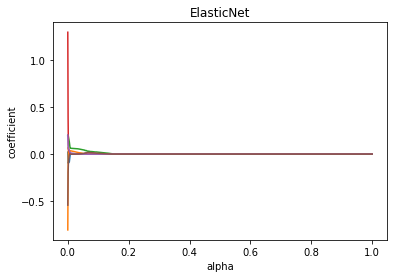

In [165]:
from sklearn.linear_model import ElasticNet
Y_ElasticNet=[]
X_ElasticNet=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=ElasticNet(alpha=i,tol=0.1)
    regrplot.fit(Train,label_)
    Y_ElasticNet.append(regrplot.coef_)
    X_ElasticNet.append(i)
Y_=np.array(Y_ElasticNet)    

plt.plot(X_ElasticNet,Y_)

plt.title('ElasticNet')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

RidgeCV coef: [-0.00437413  0.01190189  0.04742796  0.02159171  0.02001574  0.0111896 ]
RidgeCV intercept: 2.7939698976436373
Train RMSE, Mean Absolute Percentage Error
295.05354557405064 24.228767541773035


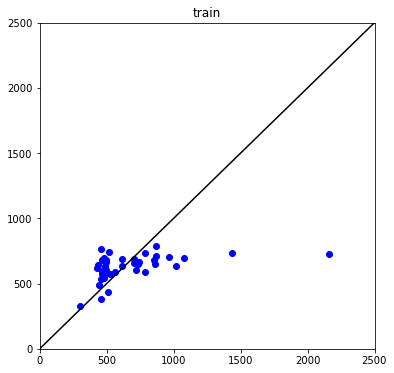

Prim RMSE, Mean Absolute Percentage Error
356.67337938175683 25.345075594651796


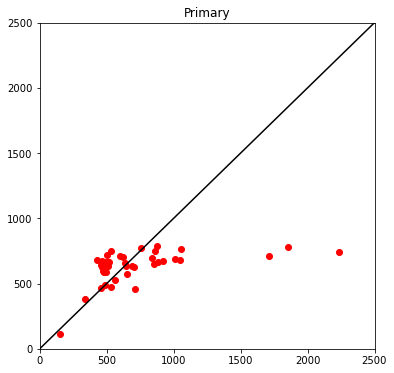

sec RMSE, Mean Absolute Percentage Error
553.7626723070643 44.275092054255616


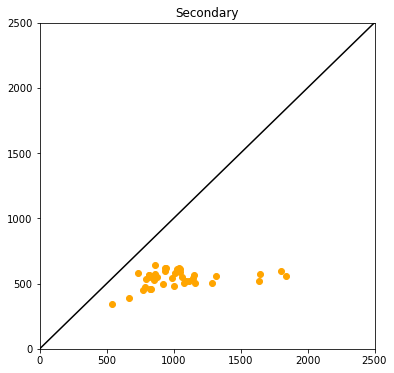

(0.0, 30.0)

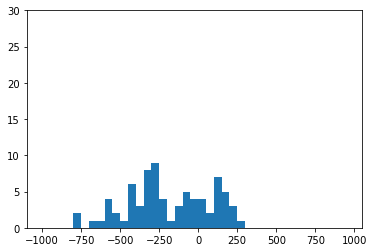

In [363]:
from sklearn.linear_model import Ridge
#from sklearn.linear_model import RidgeCV
regr=Ridge(alpha=10)
#regr=RidgeCV(cv=4)
regr.fit(Train,label_)
#print('RidgeCV alpha:',regr.alpha_)
print('RidgeCV coef:',regr.coef_)
print('RidgeCV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()


prim=np.hstack([Z1_2,Z2_2,Z3_2,Z4_2,Z5_2,Z6_2])
pred2=regr.predict(prim)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()


sec=np.hstack([Z1_3,Z2_3,Z3_3,Z4_3,Z5_3,Z6_3])
pred3=regr.predict(sec)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)

(array([0., 0., 0., 0., 2., 0., 1., 1., 4., 2., 1., 6., 3., 8., 9., 4., 1.,
        3., 5., 4., 4., 2., 7., 5., 3., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

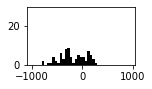

In [364]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

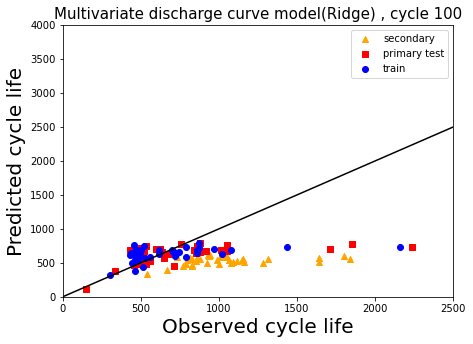

In [365]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(7,5))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,4000])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Multivariate discharge curve model(Ridge) , cycle 100',size=15)
plt.legend()
plt.show()

LassoCV alpha: 0.029253652428022397
LassoCV coef: [0.         0.00177474 0.0426581  0.00583477 0.         0.00934604]
LassoCV intercept: 2.793969897643637
Train RMSE, Mean Absolute Percentage Error
306.9475340750069 24.687799119137406


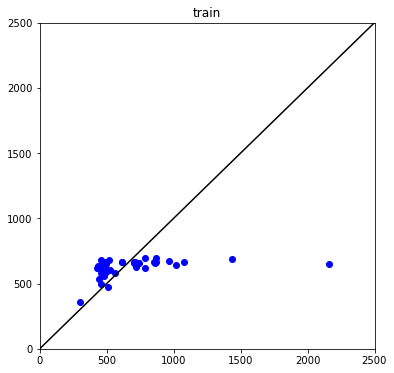

Prim RMSE, Mean Absolute Percentage Error
371.91546974994196 25.14223408898582


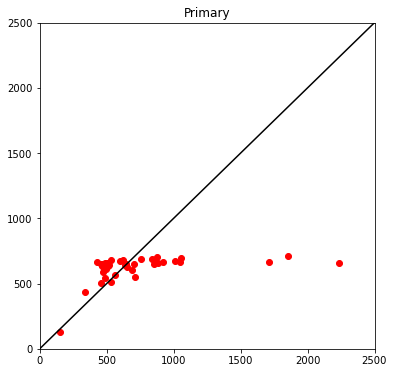

sec RMSE, Mean Absolute Percentage Error
495.05787219896143 37.01016351822936


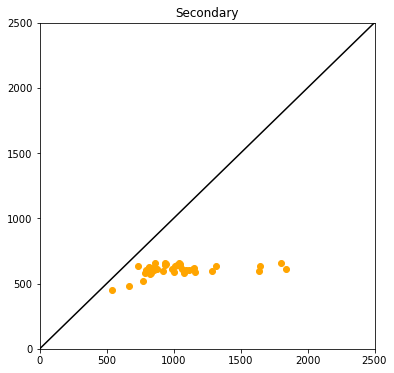

(0.0, 30.0)

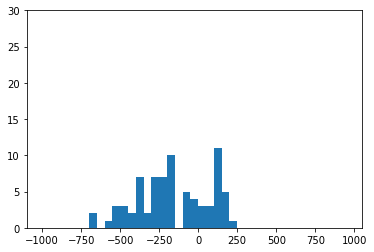

In [366]:
from sklearn.linear_model import LassoCV
regr=LassoCV(cv=4,tol=0.1)
regr.fit(Train,label_)
print('LassoCV alpha:',regr.alpha_)
print('LassoCV coef:',regr.coef_)
print('LassoCV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()


prim=np.hstack([Z1_2,Z2_2,Z3_2,Z4_2,Z5_2,Z6_2])
pred2=regr.predict(prim)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()


sec=np.hstack([Z1_3,Z2_3,Z3_3,Z4_3,Z5_3,Z6_3])
pred3=regr.predict(sec)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  3.,  3.,  2.,  7.,
         2.,  7.,  7., 10.,  0.,  5.,  4.,  3.,  3., 11.,  5.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

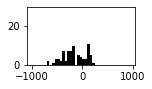

In [367]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

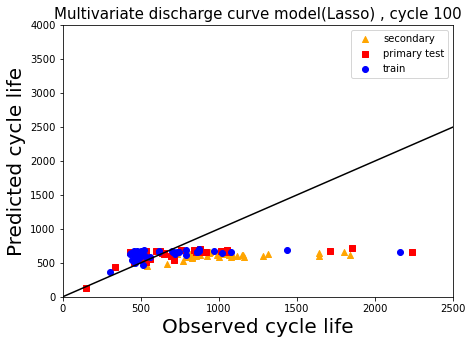

In [368]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(7,5))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,4000])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Multivariate discharge curve model(Lasso) , cycle 100',size=15)
plt.legend()
plt.show()

In [273]:
for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        print(bat_dict[j]['cycle_life'])
        continue
    print(bat_dict[j]['cycle_life'])

[[1852.]]
[[2160.]]
[[2237.]]
[[1434.]]
[[1709.]]
[[1074.]]
[[636.]]
[[870.]]
[[1054.]]
[[788.]]
[[880.]]
[[719.]]
[[862.]]
[[857.]]
[[691.]]
[[788.]]
[[534.]]
[[559.]]
[[1014.]]
[[1017.]]
[[854.]]
[[870.]]
[[842.]]
[[860.]]
[[917.]]
[[709.]]
[[876.]]
[[731.]]
[[757.]]
[[742.]]
[[703.]]
[[704.]]
[[648.]]
[[617.]]
[[625.]]
[[966.]]
[[1051.]]
[[702.]]
[[651.]]
[[616.]]
[[599.]]
[[300.]]
[[148.]]
[[438.]]
[[335.]]
[[444.]]
[[480.]]
[[511.]]
[[561.]]
[[477.]]
[[458.]]
[[483.]]
[[485.]]
[[494.]]
[[487.]]
[[461.]]
[[502.]]
[[489.]]
[[513.]]
[[527.]]
[[495.]]
[[461.]]
[[471.]]
[[468.]]
[[509.]]
[[498.]]
[[481.]]
[[492.]]
[[519.]]
[[520.]]
[[499.]]
[[463.]]
[[535.]]
[[478.]]
[[465.]]
[[459.]]
[[499.]]
[[429.]]
[[466.]]
[[462.]]
[[457.]]
[[487.]]
[[429.]]
[[713.]]
[[1009.]]
[[1063.]]
[[1115.]]
[[1048.]]
[[828.]]
[[667.]]
[[1836.]]
[[828.]]
[[1039.]]
[[1078.]]
[[817.]]
[[932.]]
[[816.]]
[[858.]]
[[876.]]
[[1638.]]
[[1315.]]
[[1146.]]
[[1155.]]
[[813.]]
[[772.]]
[[1002.]]
[[825.]]
[[989.]]
[[1028

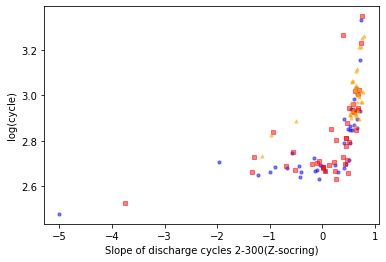

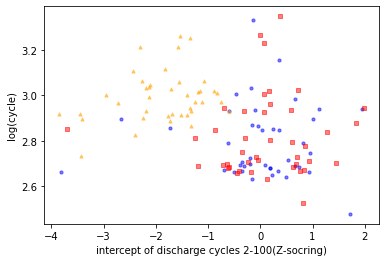

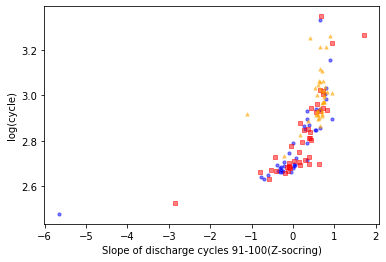

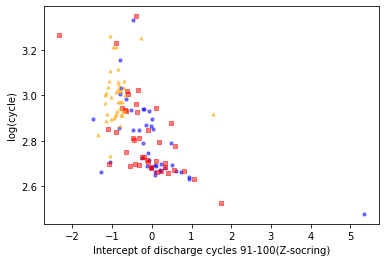

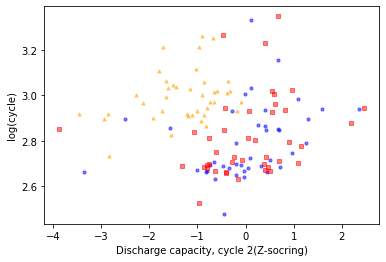

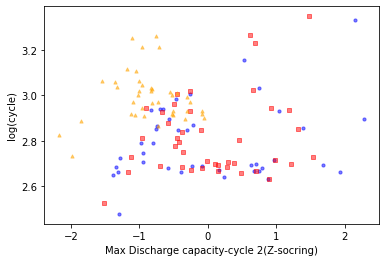

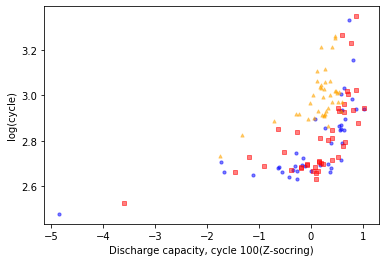

In [271]:
prim_test_cycle=[]
Train_cycle=[]
secondary_cycle=[]
for i,j in enumerate(bat1_2.keys()):
    if j=='b2c1':
        continue
    cycle=bat_dict[j]['cycle_life'].tolist()
    if i==83:
        prim_test_cycle.append(cycle)
        break
    if i%2==0:
        prim_test_cycle.append(cycle)
    if i%2==1:
        Train_cycle.append(cycle)
for i,j in enumerate(batch3.keys()):
    cycle=bat_dict[j]['cycle_life'].tolist()
    secondary_cycle.append(cycle)

cycle1=np.log10(Train_cycle)
cycle2=np.log10(prim_test_cycle)
cycle3=np.log10(secondary_cycle)    
    

cyc=np.array(cycle1).ravel()
label_=cyc

cyc2=np.array(cycle2).ravel()
label2=cyc2

cyc3=np.array(cycle3).ravel()
label3=cyc3


#Slope of capacity fade curve, cycles 2 to 300
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(2,301)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    if j=='b2c1':
        continue
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,301):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
        
    if i==83:
        prim.append(reg.coef_)
        break
    if i%2==0:
        prim.append(reg.coef_)
    if i%2==1:
        Train.append(reg.coef_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,301):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.coef_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z1_1,Z1_2,Z1_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z1_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z1_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z1_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Slope of discharge cycles 2-300(Z-socring)')
plt.show()

#Slope of capacity fade curve, cycles 2 to 300
prim=[]
Train=[]
secondary=[]
from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(2,301)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    if j=='b2c1':
        continue
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,301):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
    if i==83:
        prim.append(reg.intercept_)
        break
    if i%2==0:
        prim.append(reg.intercept_)
    if i%2==1:
        Train.append(reg.intercept_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(2,301):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.intercept_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z2_1,Z2_2,Z2_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z2_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z2_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z2_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('intercept of discharge cycles 2-100(Z-socring)')
plt.show()

# “Slope of discharge cycles 291-300”: univariate model using only the slope of the linear fit for discharge capacity, cycles 91-100
prim=[]
Train=[]
secondary=[]


prim_int=[]
Train_int=[]
secondary_int=[]



from sklearn.linear_model import LinearRegression
Xvalue=np.array(range(291,301)).reshape(-1,1)
for i,j in enumerate(bat1_2.keys()):
    if j=='b2c1':
        continue
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(291,301):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)        
        
    if i==83:
        prim.append(reg.coef_)
        prim_int.append(reg.intercept_)
        break
    if i%2==0:
        prim.append(reg.coef_)
        prim_int.append(reg.intercept_)
    if i%2==1:
        Train.append(reg.coef_)
        Train_int.append(reg.intercept_)
for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(291,301):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Xvalue,label)   
    secondary.append(reg.coef_)
    secondary_int.append(reg.intercept_)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Train_D100_int=np.array(Train_int).reshape(-1,1)
Prim_D100_int=np.array(prim_int).reshape(-1,1)
sec_D100_int=np.array(secondary_int).reshape(-1,1)

Z3_1,Z3_2,Z3_3=Z_score(Train_D100,Prim_D100,sec_D100)
Z4_1,Z4_2,Z4_3=Z_score(Train_D100_int,Prim_D100_int,sec_D100_int)

plt.scatter(Z3_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z3_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z3_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Slope of discharge cycles 91-100(Z-socring)')
plt.show()

plt.scatter(Z4_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z4_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z4_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Intercept of discharge cycles 91-100(Z-socring)')
plt.show()

# “Discharge capacity, cycle 2
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    if j=='b2c1':
        continue
    Cycle2=bat_dict[j]['summary']['QD'][2]

    if i==83:
        prim.append(Cycle2)
        break
    if i%2==0:
        prim.append(Cycle2)
    if i%2==1:
        Train.append(Cycle2)
for i,j in enumerate(batch3.keys()):
    Cycle2=bat_dict[j]['summary']['QD'][2]
    secondary.append(Cycle2)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z5_1,Z5_2,Z5_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z5_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z5_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z5_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Discharge capacity, cycle 2(Z-socring)')
plt.show()

# “Max Discharge capacity-cycle 2'
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    if j=='b2c1':
        continue
    a=np.array(bat_dict[j]['summary']['QD'])
    de=np.where(a>1.2)
    a=np.delete(a,de)
    max_Q_cycle2=max(a)-a[2]
    
    if i==83:
        prim.append(max_Q_cycle2)
        break
    if i%2==0:
        prim.append(max_Q_cycle2)
    if i%2==1:
        Train.append(max_Q_cycle2)
for i,j in enumerate(batch3.keys()):
    a=np.array(bat_dict[j]['summary']['QD'])
    de=np.where(a>1.2)
    a=np.delete(a,de)
    max_Q_cycle2=max(a)-a[2]
    secondary.append(max_Q_cycle2)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z6_1,Z6_2,Z6_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z6_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z6_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z6_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Max Discharge capacity-cycle 2(Z-socring)')
plt.show()

# “Discharge capacity, cycle 300'
prim=[]
Train=[]
secondary=[]
for i,j in enumerate(bat1_2.keys()):
    if j=='b2c1':
        continue
    Cycle100=bat_dict[j]['summary']['QD'][300]

    if i==83:
        prim.append(Cycle100)
        break
    if i%2==0:
        prim.append(Cycle100)
    if i%2==1:
        Train.append(Cycle100)
for i,j in enumerate(batch3.keys()):
    Cycle100=bat_dict[j]['summary']['QD'][300]
    secondary.append(Cycle100)
    
Train_D100=np.array(Train).reshape(-1,1)
Prim_D100=np.array(prim).reshape(-1,1)
sec_D100=np.array(secondary).reshape(-1,1)

Z7_1,Z7_2,Z7_3=Z_score(Train_D100,Prim_D100,sec_D100)

plt.scatter(Z7_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
plt.scatter(Z7_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
plt.scatter(Z7_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
plt.ylabel('log(cycle)')
plt.xlabel('Discharge capacity, cycle 100(Z-socring)')
plt.show()

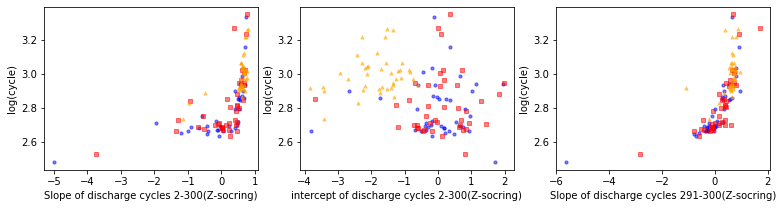

<Figure size 432x288 with 0 Axes>

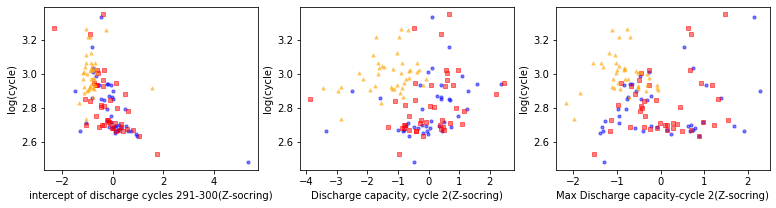

<Figure size 432x288 with 0 Axes>

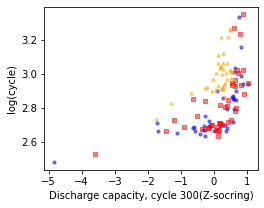

In [272]:
fig=plt.figure(figsize=(13,3))
ax1=fig.add_subplot(1,3,1)
ax1.scatter(Z1_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax1.scatter(Z1_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax1.scatter(Z1_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax1.set_ylabel('log(cycle)')
ax1.set_xlabel('Slope of discharge cycles 2-300(Z-socring)')

ax2=fig.add_subplot(1,3,2)
ax2.scatter(Z2_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax2.scatter(Z2_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax2.scatter(Z2_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax2.set_ylabel('log(cycle)')
ax2.set_xlabel('intercept of discharge cycles 2-300(Z-socring)')

ax3=fig.add_subplot(1,3,3)
ax3.scatter(Z3_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax3.scatter(Z3_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax3.scatter(Z3_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax3.set_ylabel('log(cycle)')
ax3.set_xlabel('Slope of discharge cycles 291-300(Z-socring)')
plt.show()

plt.clf()
fig=plt.figure(figsize=(13,3))
ax4=fig.add_subplot(1,3,1)
ax4.scatter(Z4_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax4.scatter(Z4_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax4.scatter(Z4_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax4.set_ylabel('log(cycle)')
ax4.set_xlabel('intercept of discharge cycles 291-300(Z-socring)')

ax5=fig.add_subplot(1,3,2)
ax5.scatter(Z5_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax5.scatter(Z5_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax5.scatter(Z5_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax5.set_ylabel('log(cycle)')
ax5.set_xlabel('Discharge capacity, cycle 2(Z-socring)')

ax6=fig.add_subplot(1,3,3)
ax6.scatter(Z6_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax6.scatter(Z6_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax6.scatter(Z6_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax6.set_ylabel('log(cycle)')
ax6.set_xlabel('Max Discharge capacity-cycle 2(Z-socring)')
plt.show()

plt.clf()
fig=plt.figure(figsize=(13,3))
ax7=fig.add_subplot(1,3,1)
ax7.scatter(Z7_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax7.scatter(Z7_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax7.scatter(Z7_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax7.set_ylabel('log(cycle)')
ax7.set_xlabel('Discharge capacity, cycle 300(Z-socring)')
plt.show()

In [274]:
Train=np.hstack([Z1_1,Z2_1,Z3_1,Z4_1,Z5_1,Z6_1,Z7_1])
Train.shape , label_.shape

((41, 7), (41,))

Elastic Net CV alpha: 0.10204859804292948
Elastic Net CV coef: [ 0.          0.          0.02698106 -0.          0.          0.
  0.02627582]
Elastic Net CV intercept: 2.793969897643637
Train RMSE, Mean Absolute Percentage Error
297.5275315257469 23.013853851949293


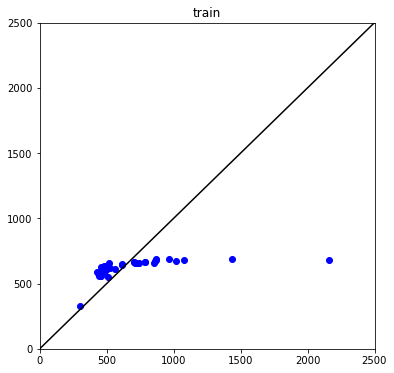

Prim RMSE, Mean Absolute Percentage Error
369.06297881391623 24.288740123517073


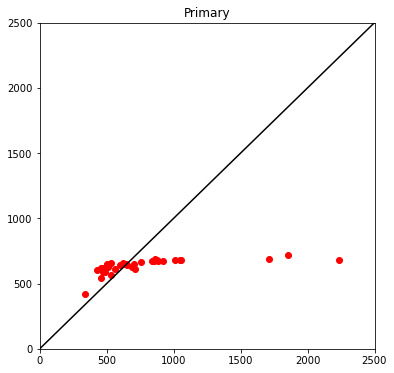

sec RMSE, Mean Absolute Percentage Error
460.5450185554663 32.42375996814945


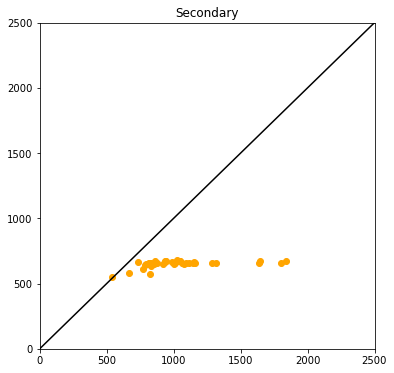

(0.0, 30.0)

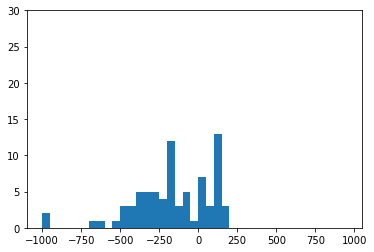

In [275]:
#elasticnet
from sklearn.linear_model import ElasticNetCV
regr=ElasticNetCV(cv=4,tol=0.01)
regr.fit(Train,label_)
print('Elastic Net CV alpha:',regr.alpha_)
print('Elastic Net CV coef:',regr.coef_)
print('Elastic Net CV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()


prim=np.hstack([Z1_2,Z2_2,Z3_2,Z4_2,Z5_2,Z6_2,Z7_2])
pred2=regr.predict(prim)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()


sec=np.hstack([Z1_3,Z2_3,Z3_3,Z4_3,Z5_3,Z6_3,Z7_3])
pred3=regr.predict(sec)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  3.,  3.,  5.,
         5.,  5.,  4., 12.,  3.,  5.,  1.,  7.,  3., 13.,  3.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

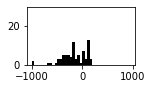

In [276]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

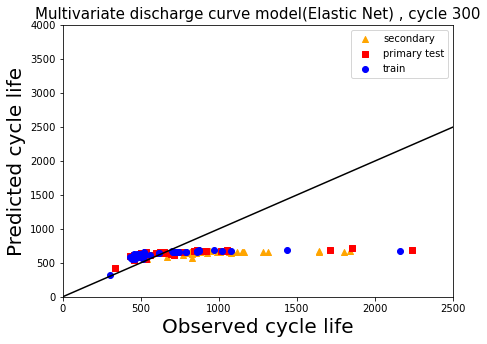

In [277]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(7,5))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,4000])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Multivariate discharge curve model(Elastic Net) , cycle 300',size=15)
plt.legend()
plt.show()

RidgeCV alpha: 10.0
RidgeCV coef: [ 0.01123781 -0.00953516  0.02739243 -0.02973931  0.04215162  0.02067148
  0.01870039]
RidgeCV intercept: 2.7939698976436382
Train RMSE, Mean Absolute Percentage Error
265.98588538125784 19.579156737752236


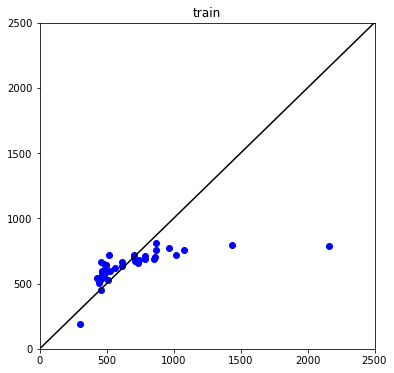

Prim RMSE, Mean Absolute Percentage Error
335.10230209974156 22.342276855419783


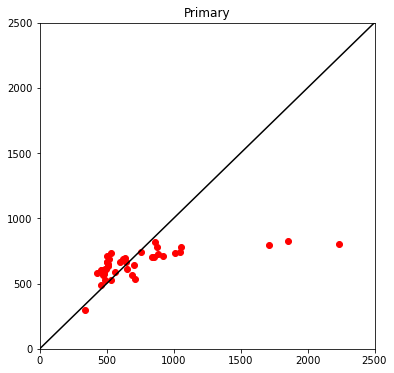

sec RMSE, Mean Absolute Percentage Error
485.6979151469845 36.01929811460368


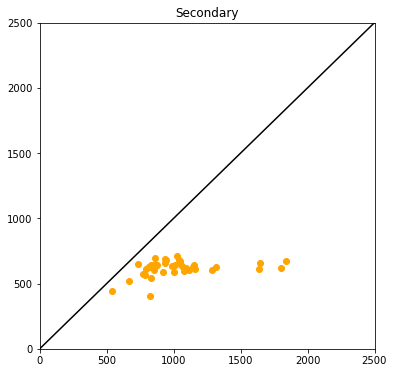

(0.0, 30.0)

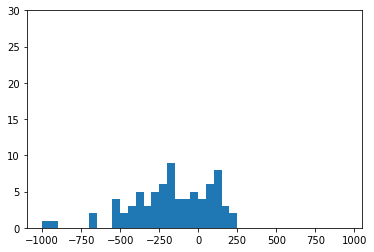

In [278]:
#elasticnet
from sklearn.linear_model import RidgeCV
regr=RidgeCV(cv=4)
regr.fit(Train,label_)
print('RidgeCV alpha:',regr.alpha_)
print('RidgeCV coef:',regr.coef_)
print('RidgeCV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()


prim=np.hstack([Z1_2,Z2_2,Z3_2,Z4_2,Z5_2,Z6_2,Z7_2])
pred2=regr.predict(prim)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()


sec=np.hstack([Z1_3,Z2_3,Z3_3,Z4_3,Z5_3,Z6_3,Z7_3])
pred3=regr.predict(sec)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)

(array([1., 1., 0., 0., 0., 0., 2., 0., 0., 4., 2., 3., 5., 3., 5., 6., 9.,
        4., 4., 5., 4., 6., 8., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

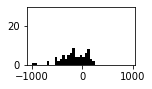

In [279]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

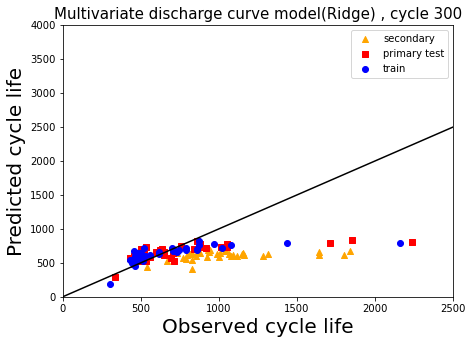

In [280]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(7,5))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,4000])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Multivariate discharge curve model(Ridge) , cycle 300',size=15)
plt.legend()
plt.show()

LassoCV alpha: 0.05102429902146478
LassoCV coef: [ 0.          0.          0.0278526  -0.          0.          0.
  0.02684519]
LassoCV intercept: 2.793969897643637
Train RMSE, Mean Absolute Percentage Error
296.8418159149278 22.855279281168603


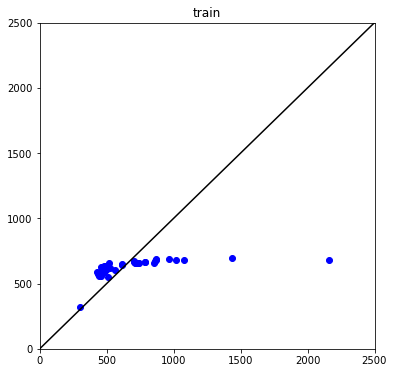

Prim RMSE, Mean Absolute Percentage Error
368.2742705452197 24.198721746899604


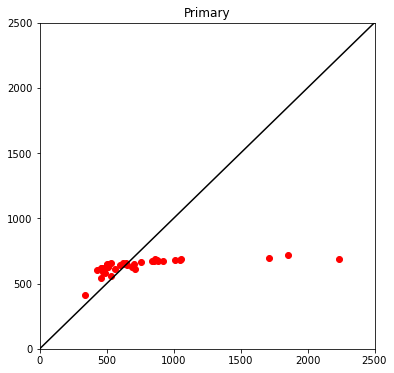

sec RMSE, Mean Absolute Percentage Error
459.6519237161199 32.32273712171693


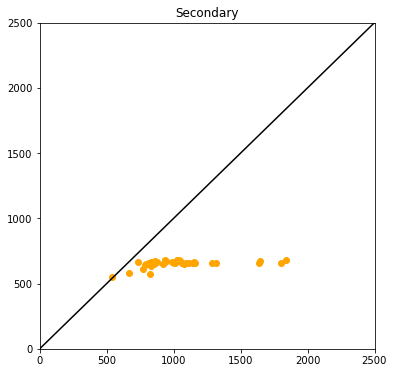

(0.0, 30.0)

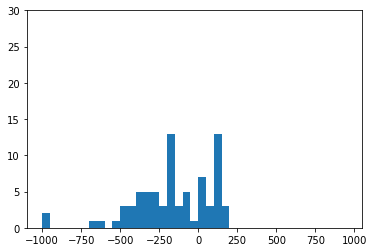

In [281]:
#elasticnet
from sklearn.linear_model import LassoCV
regr=LassoCV(cv=4,tol=0.01)
regr.fit(Train,label_)
print('LassoCV alpha:',regr.alpha_)
print('LassoCV coef:',regr.coef_)
print('LassoCV intercept:',regr.intercept_)

pred1=regr.predict(Train)


rmse1=np.sqrt(mean_squared_error(10**label_,10**pred1))
MAPE1=MAPE(10**label_,10**pred1)
print('Train RMSE, Mean Absolute Percentage Error')
print(rmse1,MAPE1)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label_,10**pred1,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()


prim=np.hstack([Z1_2,Z2_2,Z3_2,Z4_2,Z5_2,Z6_2,Z7_2])
pred2=regr.predict(prim)


rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('Prim RMSE, Mean Absolute Percentage Error')
print(rmse2,MAPE2)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='o')
plt.title('Primary')
plt.axis([0,2500,0,2500])
plt.show()


sec=np.hstack([Z1_3,Z2_3,Z3_3,Z4_3,Z5_3,Z6_3,Z7_3])
pred3=regr.predict(sec)


rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('sec RMSE, Mean Absolute Percentage Error')
print(rmse3,MAPE3)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='o')
plt.title('Secondary')
plt.axis([0,2500,0,2500])
plt.show()

s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  3.,  3.,  5.,
         5.,  5.,  3., 13.,  3.,  5.,  1.,  7.,  3., 13.,  3.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

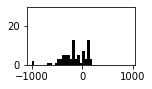

In [282]:
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')

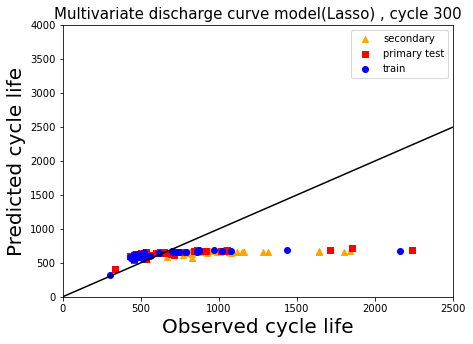

In [283]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(7,5))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred1,color='blue',marker='o',label='train')
plt.axis([0,2500,0,4000])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Multivariate discharge curve model(Lasso) , cycle 300',size=15)
plt.legend()
plt.show()

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14985584670492877, tolerance: 0.10703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

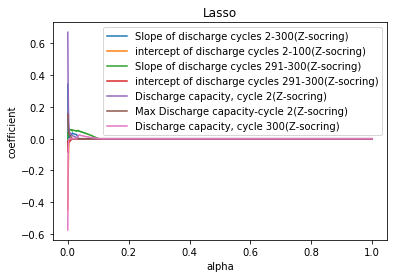

In [290]:
Y_lasso=[]
X_lasso=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Lasso(alpha=i,tol=0.1)
    regrplot.fit(Train,label_)
    Y_lasso.append(regrplot.coef_)
    X_lasso.append(i)
Y_=np.array(Y_lasso)    


plt.plot(X_lasso,Y_[:,0],label='Slope of discharge cycles 2-300(Z-socring)')
plt.plot(X_lasso,Y_[:,1],label='intercept of discharge cycles 2-100(Z-socring)')
plt.plot(X_lasso,Y_[:,2],label='Slope of discharge cycles 291-300(Z-socring)')
plt.plot(X_lasso,Y_[:,3],label='intercept of discharge cycles 291-300(Z-socring)')
plt.plot(X_lasso,Y_[:,4],label='Discharge capacity, cycle 2(Z-socring)')
plt.plot(X_lasso,Y_[:,5],label='Max Discharge capacity-cycle 2(Z-socring)')
plt.plot(X_lasso,Y_[:,6],label='Discharge capacity, cycle 300(Z-socring)')

plt.title('Lasso')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

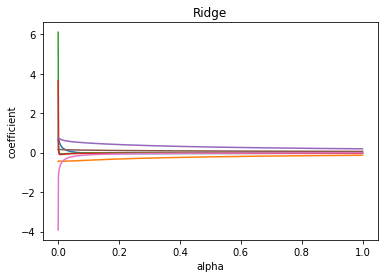

In [285]:
Y_Ridge=[]
X_Ridge=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=Ridge(alpha=i,tol=0.1)
    regrplot.fit(Train,label_)
    Y_Ridge.append(regrplot.coef_)
    X_Ridge.append(i)
Y_=np.array(Y_Ridge)    

plt.plot(X_Ridge,Y_)

plt.title('Ridge')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14985584670492877, tolerance: 0.10703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

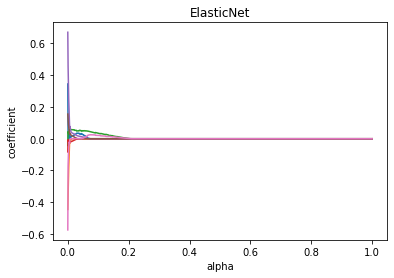

In [286]:
from sklearn.linear_model import ElasticNet
Y_ElasticNet=[]
X_ElasticNet=[]
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,1,1000):
    regrplot=ElasticNet(alpha=i,tol=0.1)
    regrplot.fit(Train,label_)
    Y_ElasticNet.append(regrplot.coef_)
    X_ElasticNet.append(i)
Y_=np.array(Y_ElasticNet)    

plt.plot(X_ElasticNet,Y_)

plt.title('ElasticNet')
plt.xlabel('alpha')
plt.ylabel('coefficient')
plt.show